In [1]:
import copy
import glob
import os
import tqdm

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import mpl_toolkits.axes_grid1
import japanize_matplotlib

import astropy
import astropy.io.fits
import astropy.units as u
import astroquery.vizier
from astropy.wcs import WCS
from spectral_cube import SpectralCube
import pylab


pylab.rcParams['font.family'] = 'serif'
pylab.rcParams['lines.linewidth'] = 0.5
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 15
pylab.rcParams["xtick.direction"] = "in"
pylab.rcParams["ytick.direction"] = "in"

In [3]:
import sys
# sys.path.append('/home/elmegreen/galactic_bubble/photoutils/')
from processing import norm_res, normalize_rp, remove_nan, conv, data_view_rectangl, resize
from utils.ssd_model import nm_suppression

# sys.path.append('/home/elmegreen/jupyter/research/Bubble_Analysis/CO_SpitzerBubble/All_Bubble_Analysis/Analysis')
from Function_to_Detect_peak import find_verified_peak, _detect_and_characterize_peak, find_velocity_from_catalog, _check_signal_at_channel, gaussian_filter

In [4]:
viz = astroquery.vizier.Vizier(columns=["*"])
viz.ROW_LIMIT = -1
bub_velocity_table = viz.query_constraints(catalog="J/MNRAS/438/426")[0].to_pandas()

# GLONを0-360度の範囲に正規化
bub_velocity_table['GLON'] = bub_velocity_table['GLON'] % 360
bub_velocity_table['GLON2'] = bub_velocity_table['GLON2'] % 360

print(f"読み込んだバブル速度カタログのエントリ数: {len(bub_velocity_table)}")
print("カタログの列名:", bub_velocity_table.columns.tolist())

読み込んだバブル速度カタログのエントリ数: 818
カタログの列名: ['MWP', 'GLON', 'GLAT', 'Reff', 'GLON2', 'GLAT2', 'Ref', 'VHII', 'D0', 'e_D0', 'r_D0', 'DK', 'e_DK', 'Mark', 'r_Mark', 'Simbad', '_RA.icrs', '_DE.icrs']


In [4]:
all_bubble_catalogue = pd.read_csv('/home/elmegreen/jupyter/research/Bubble_Analysis/CO_SpitzerBubble/All_Bubble_Analysis/infer_catalogue_all.csv')
all_bubble_catalogue['ra_center'] = (all_bubble_catalogue['ra_min'] + all_bubble_catalogue['ra_max'])/2
all_bubble_catalogue['dec_center'] = (all_bubble_catalogue['dec_min'] + all_bubble_catalogue['dec_max'])/2
all_bubble_catalogue = all_bubble_catalogue[2000:]
all_bubble_catalogue.head()

,Unnamed: 0,dec_min,ra_min,dec_max,ra_max,fits_path,ra_center,dec_center
2000,0,-0.320890,49.400961,-0.283730,49.437063,spitzer_04800+0000_rgb,49.419012,-0.302310
2001,0,0.186576,46.987243,0.260011,47.056958,spitzer_04800+0000_rgb,47.022100,0.223293
2002,0,-0.026486,48.571747,-0.001735,48.596749,spitzer_04800+0000_rgb,48.584248,-0.014111
2003,0,-0.017088,49.420572,0.001843,49.439933,spitzer_04800+0000_rgb,49.430252,-0.007623
2004,0,-0.282454,49.368145,-0.250468,49.401196,spitzer_04800+0000_rgb,49.384671,-0.266461


In [5]:
fugin_path_list = sorted(
    glob.glob(
        '/home/elmegreen/jupyter/fits_data/FGN_fits/12CO/**'))
print(len(fugin_path_list))
print(fugin_path_list[0])

39
/home/elmegreen/jupyter/fits_data/FGN_fits/12CO/FGN_01100+0000_2x2_12CO_v1.00_cube.fits


In [6]:
zeroing_fugin_path_list = sorted(
    glob.glob(
        '/home/elmegreen/jupyter/research/Bubble_Analysis/CO_SpitzerBubble/All_Bubble_Analysis/Analysis/Fits/Zeroing_Fits/12CO/**'))
print(len(zeroing_fugin_path_list))
print(zeroing_fugin_path_list[0])

39
/home/elmegreen/jupyter/research/Bubble_Analysis/CO_SpitzerBubble/All_Bubble_Analysis/Analysis/Fits/Zeroing_Fits/12CO/FGN_01100


In [7]:
def extract_spectral(w_co, fugin_cube_fits, each_catalogue):

    # **************************************
    bubble_x_min, bubble_y_min, _ = w_co.all_world2pix(each_catalogue['ra_max'], each_catalogue['dec_min'], 0, 0)
    bubble_x_max, bubble_y_max, _ = w_co.all_world2pix(each_catalogue['ra_min'], each_catalogue['dec_max'], 0, 0)
    radius_pix = (bubble_y_max - bubble_y_min) * 1/2
    # **************************************
    
    cut_data = fugin_cube_fits.data[:, 
    int(bubble_y_min - radius_pix):int(bubble_y_max + radius_pix), 
    int(bubble_x_min - radius_pix):int(bubble_x_max + radius_pix)]
    # print(radius_pix)
    # print(int(bubble_y_min - radius_pix), int(bubble_y_max + radius_pix), int(bubble_x_min - radius_pix), int(bubble_x_max + radius_pix))

    return cut_data

In [8]:
def make_spitzer_fits(spitzer_rfits, spitzer_gfits, w_spitzer, data, row):
    header = spitzer_rfits.header
    x, y = w_spitzer.all_world2pix((row["ra_max"]+row["ra_min"])/2, 
                           (row["dec_min"]+row["dec_max"])/2, 0)

    x_min, y_min = w_spitzer.all_world2pix(row["ra_max"], row["dec_min"], 0)
    x_max, y_max = w_spitzer.all_world2pix(row["ra_min"], row["dec_max"], 0)
    r = (x_max - x_min)*1

    x_pix_min = x_min - r/2
    y_pix_min = y_min - r/2
    x_pix_max = x_max + r/2
    y_pix_max = y_max + r/2

    if x_pix_min<=0 or y_pix_min<=0:
        return 0, 0
    else:
        c_data = data[int(y_pix_min):int(y_pix_max), int(x_pix_min):int(x_pix_max)].view()
        cut_data = copy.deepcopy(c_data)
        r_shape_y = cut_data.shape[0]
        r_shape_x = cut_data.shape[1]
        cut_data = normalize_rp(cut_data.copy(), 
                                spitzer_rfits.header["PIXSCAL1"], spitzer_gfits.header["PIXSCAL1"])
        
        header['CRVAL1'] = (row["ra_max"] + row["ra_min"])/2
        header['CRVAL2'] = (row["dec_max"] + row["dec_min"])/2
        header['RA'] = (row["ra_max"] + row["ra_min"])/2
        header['DEC'] = (row["dec_max"] + row["dec_min"])/2
        header['CRPIX1'] = cut_data.shape[0]/2
        header['CRPIX2'] = cut_data.shape[1]/2
        header['NAXIS1'] = cut_data.shape[0]
        header['NAXIS2'] = cut_data.shape[1]
        header['CDELT2'] = header['CD2_2']

        new_hdu = astropy.io.fits.PrimaryHDU(cut_data[:,:,0], header)
        new_hdu_list_r = astropy.io.fits.HDUList([new_hdu])
        new_hdu = astropy.io.fits.PrimaryHDU(cut_data[:,:,1], header)
        new_hdu_list_g = astropy.io.fits.HDUList([new_hdu])


        return new_hdu_list_r, new_hdu_list_g

In [9]:
def load_spitzer_fits(spitzer_path):
    spitzer_rfits = astropy.io.fits.open(spitzer_path + 'r.fits')[0]
    spitzer_gfits = astropy.io.fits.open(spitzer_path + 'g.fits')[0]
    spitzer_data = np.concatenate([
        remove_nan(spitzer_rfits.data[:,:,None]),
        remove_nan(spitzer_gfits.data[:,:,None]),
        np.zeros(spitzer_rfits.data.shape)[:,:,None]], axis=2)
    w_spitzer = astropy.wcs.WCS(spitzer_rfits.header)

    return spitzer_rfits, spitzer_gfits, spitzer_data, w_spitzer

In [10]:
# 詳細な統計情報を追跡するための変数を初期化
velocity_stats = {
    'catalogue_vel_bubble': 0,
    'catalogue_vel_with_c18o': 0,  # 新規追加：カタログ速度使用かつC18Oピークあり
    'c18o_vel_bubble': 0,
    'co13_vel_bubble': 0,
    'no_vel_bubble': 0,
    'spitzer_error_bubble': 0,
    'total_bubble': 0
}

In [11]:
def make_momont012_map(w_co, cut_data, vi, v_center=None):
    """
    Moment 0, 1, 2 マップを作成
    
    Args:
        w_co: WCS情報
        cut_data: 3次元データキューブ (velocity, y, x)
        vi: 速度軸の配列
        v_center: 中心速度（この速度を0とする）。Noneの場合は従来通り
    
    Returns:
        dict: moment0, moment1, moment2を含む辞書
    """
    moment1, moment2 = [], []

    # Making Moment0 map
    moment0 = np.nansum(cut_data, axis=0) * dv

    # 中心速度が指定されている場合、速度軸をシフト
    if v_center is not None:
        vi_shifted = vi - v_center  # 中心速度を0にシフト
    else:
        vi_shifted = vi

    # Making Moment1+2 map
    for i in range(cut_data.shape[1]):
        for j in range(cut_data.shape[2]):
            I = cut_data[:, i, j]
            
            # Moment 1の計算（シフトした速度を使用）
            aa = I * vi_shifted * dv
            sgm = np.nansum(aa)
            MM = np.nansum(cut_data[:, i, j], axis=0) * dv
            
            if MM > 0:  # ゼロ除算を避ける
                intg = sgm / MM
            else:
                intg = np.nan
                
            moment1.append(intg)

            # Moment 2の計算
            if not np.isnan(intg) and MM > 0:
                bb = I * ((vi_shifted - intg) ** 2) * dv
                cc = np.nansum(bb, axis=0)
                dd = cc / MM
                MM2 = np.sqrt(dd)  # (dd) ** (1/2) をより明確に
            else:
                MM2 = np.nan
                
            moment2.append(MM2)
        
    moment1 = np.array(moment1).reshape(cut_data.shape[1], cut_data.shape[2])
    moment2 = np.array(moment2).reshape(cut_data.shape[1], cut_data.shape[2])

    return {'cut_data': cut_data, 'moment0': moment0, 'moment1': moment1, 'moment2': moment2}

In [12]:
# 各バブルの詳細情報を記録するリスト
bubble_details = []

for each_path, zeroing_each_path in tqdm.tqdm(zip(fugin_path_list[:1], zeroing_fugin_path_list[:1])):
    # パスやディレクトリの設定
    base_dir = os.path.dirname(os.path.dirname(each_path))
    region_name = each_path.split('/')[-1].split('+')[0]
    output_fig_dir = os.path.join('Spectral_fig', region_name)
    os.makedirs(output_fig_dir, exist_ok=True)

    Zeroing_12CO_fits_path = glob.glob(
        '/'.join(zeroing_each_path.split('/')[:-2]) + "/12CO/" + region_name + f"/{region_name}**.fits")[0]
    Zeroing_13CO_fits_path = glob.glob(
        '/'.join(zeroing_each_path.split('/')[:-2]) + "/13CO/" + region_name + f"/{region_name}**.fits")[0]
    Zeroing_C18O_fits_path = glob.glob(
        '/'.join(zeroing_each_path.split('/')[:-2]) + "/C18O/" + region_name + f"/{region_name}**.fits")[0]
    Zeroing_fugin_cube_fits_12CO = astropy.io.fits.open(Zeroing_12CO_fits_path)[0]
    Zeroing_fugin_cube_fits_13CO = astropy.io.fits.open(Zeroing_13CO_fits_path)[0]
    Zeroing_fugin_cube_fits_C18O = astropy.io.fits.open(Zeroing_C18O_fits_path)[0]

    # FITSファイルのパスを構築
    _12CO_fits_path = os.path.join(base_dir, "12CO", f"{region_name}+0000_2x2_12CO_v1.00_cube.fits")
    _13CO_fits_path = os.path.join(base_dir, "13CO", f"{region_name}+0000_2x2_13CO_v1.00_cube.fits")
    C18O_fits_path = glob.glob(os.path.join(base_dir, "C18O", f"{region_name}+0000_2x2_C18O_v1.*.fits"))[0]

    # FITSファイルを開く
    fugin_cube_fits_12CO = astropy.io.fits.open(_12CO_fits_path)[0]
    fugin_cube_fits_13CO = astropy.io.fits.open(_13CO_fits_path)[0]
    fugin_cube_fits_C18O = astropy.io.fits.open(C18O_fits_path)[0]

    # WCSと速度軸の情報を抽出
    w_co = astropy.wcs.WCS(fugin_cube_fits_12CO.header)
    cube = SpectralCube.read(fugin_cube_fits_12CO)
    vaxis = cube.spectral_axis.to_value(u.km/u.s)
    dv = abs(fugin_cube_fits_12CO.header['CDELT3']) / 1000.0

    # カタログフィルタリング
    ny, nx = fugin_cube_fits_12CO.data.shape[1:3]
    glon_min, glat_min, _ = w_co.all_pix2world(nx, 0, 0, 0)
    glon_max, glat_max, _ = w_co.all_pix2world(0, ny, 0, 0)
    all_bubble_catalogue_selected = all_bubble_catalogue.query(
        f"{glon_min} <= ra_center <= {glon_max} and {glat_min} <= dec_center <= {glat_max}"
    ).reset_index()

    spitzer_path_cached = None

1it [00:00, 60.61it/s]


In [13]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']


Catalogue 0: Found velocity in catalog - Row 84, VHII=23.8 km/s, MWP=1G011895+007508
  -> Also has C18O peak at 25.1 km/s (within ±10 km/s of catalog)


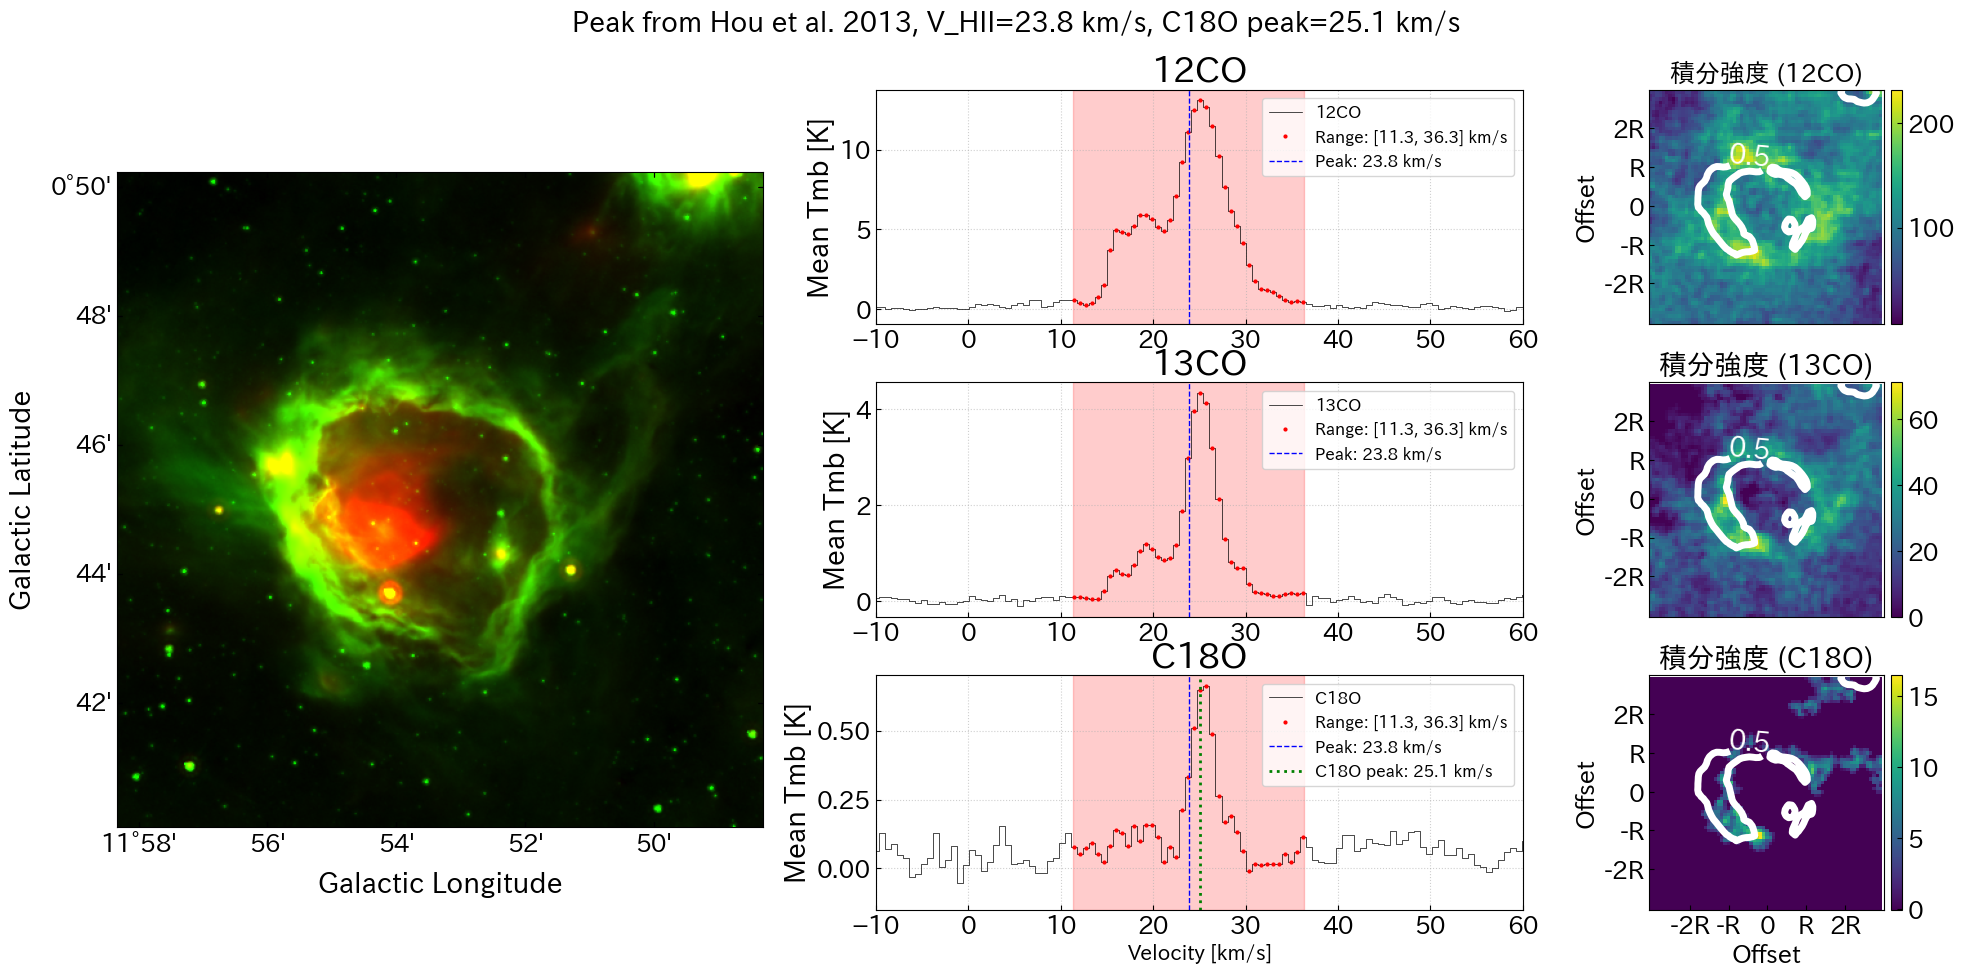

In [14]:
for i, each_catalogue in all_bubble_catalogue_selected[:1].iterrows():
    velocity_stats['total_bubble'] += 1
    
    # 各バブルの情報を初期化
    bubble_info = {
        'region': region_name,
        'catalogue_index': i,
        'ra_center': each_catalogue['ra_center'],
        'dec_center': each_catalogue['dec_center'],
        'velocity_source': None,
        'v_peak': None,
        'fwhm_vel': None,
        'has_c18o_peak': False,  # 新規追加
        'status': None
    }
    
    # Spitzerデータのロード（キャッシュを利用）
    current_spitzer_path = os.path.join("/home/elmegreen/jupyter/fits_data/spitzer_data", each_catalogue['fits_path']+'/',)
    if current_spitzer_path != spitzer_path_cached:
        spitzer_rfits, spitzer_gfits, spitzer_data, w_spitzer = load_spitzer_fits(current_spitzer_path)
        spitzer_path_cached = current_spitzer_path

    # スペクトルデータを抽出
    cut_data_12CO = extract_spectral(w_co, fugin_cube_fits_12CO, each_catalogue)
    cut_data_13CO = extract_spectral(w_co, fugin_cube_fits_13CO, each_catalogue)
    cut_data_C18O = extract_spectral(w_co, fugin_cube_fits_C18O, each_catalogue)

    zeroing_cut_data_12CO = extract_spectral(w_co, Zeroing_fugin_cube_fits_12CO, each_catalogue)
    zeroing_cut_data_13CO = extract_spectral(w_co, Zeroing_fugin_cube_fits_13CO, each_catalogue)
    zeroing_cut_data_C18O = extract_spectral(w_co, Zeroing_fugin_cube_fits_C18O, each_catalogue)

    # 平均スペクトルを計算
    mean_data_12CO = np.nanmean(cut_data_12CO, axis=(1, 2))
    mean_data_13CO = np.nanmean(cut_data_13CO, axis=(1, 2))
    mean_data_C18O = np.nanmean(cut_data_C18O, axis=(1, 2))

    # C18Oのピーク検証を常に実行（統計のため）
    c18o_v_peak, c18o_t_peak, c18o_fwhm_vel, c18o_peak_channel = find_verified_peak(
        c18o_spec=mean_data_C18O,
        co12_spec=mean_data_12CO,
        co13_spec=mean_data_13CO,
        vaxis=vaxis, dv=dv
    )
    
    # C18Oピークの存在を記録（後でカタログ値との比較で更新される可能性あり）
    bubble_info['has_c18o_peak'] = c18o_v_peak is not None

    # まずカタログから速度情報を検索
    catalog_v_peak, catalog_fwhm_vel, catalog_info = find_velocity_from_catalog(
        each_catalogue['ra_center'], 
        each_catalogue['dec_center'], 
        bub_velocity_table,
        search_radius=(each_catalogue['dec_max'] - each_catalogue['dec_min'])/2
    )

    # カタログから速度情報が見つかった場合
    if catalog_v_peak is not None:
        print(f"Catalogue {i}: Found velocity in catalog - Row {catalog_info['catalog_index']}, "
              f"VHII={catalog_v_peak:.1f} km/s, MWP={catalog_info['MWP']}")
        
        # C18Oピークがカタログ値の±10km/s以内にあるかチェック
        if bubble_info['has_c18o_peak'] and abs(c18o_v_peak - catalog_v_peak) <= 10.0:
            print(f"  -> Also has C18O peak at {c18o_v_peak:.1f} km/s (within ±10 km/s of catalog)")
            velocity_stats['catalogue_vel_with_c18o'] += 1
            bubble_info['has_c18o_peak'] = True  # ±10km以内の場合のみTrue
        elif bubble_info['has_c18o_peak']:
            print(f"  -> C18O peak at {c18o_v_peak:.1f} km/s is outside ±10 km/s range (diff: {abs(c18o_v_peak - catalog_v_peak):.1f} km/s)")
            bubble_info['has_c18o_peak'] = False  # ±10km外の場合はFalse
        
        used_tracer = f"Catalog (Row {catalog_info['catalog_index']})"
        v_peak = catalog_v_peak
        fwhm_vel = catalog_fwhm_vel
        t_peak = np.nan
        peak_channel = np.argmin(np.abs(vaxis - v_peak))
        velocity_stats['catalogue_vel_bubble'] += 1
        bubble_info['velocity_source'] = 'Catalog'
        bubble_info['v_peak'] = v_peak
        bubble_info['fwhm_vel'] = fwhm_vel
        bubble_info['status'] = 'Success'
        
    # カタログに見つからなかった場合はC18Oを試す
    elif c18o_v_peak is not None:
        used_tracer = "C18O (verified)"
        v_peak = c18o_v_peak
        t_peak = c18o_t_peak
        fwhm_vel = c18o_fwhm_vel
        peak_channel = c18o_peak_channel
        velocity_stats['c18o_vel_bubble'] += 1
        bubble_info['velocity_source'] = 'C18O'
        bubble_info['v_peak'] = v_peak
        bubble_info['fwhm_vel'] = fwhm_vel
        bubble_info['status'] = 'Success'
        
    else:
        # C18Oで検証済みピークが見つからなかった場合、13COにフォールバック
        print(f"No verified C18O peak for catalogue {i}. Falling back to 13CO.")
        used_tracer = "13CO"
        v_peak, t_peak, fwhm_vel, peak_channel = _detect_and_characterize_peak(
            mean_data_13CO, vaxis, dv,
            height_factor=5.0, prominence_factor=3.0
        )

        if v_peak is not None:
            velocity_stats['co13_vel_bubble'] += 1
            bubble_info['velocity_source'] = '13CO'
            bubble_info['v_peak'] = v_peak
            bubble_info['fwhm_vel'] = fwhm_vel
            bubble_info['status'] = 'Success'
        else:
            # 13COでも見つからなければスキップ
            print(f"No significant peak in 13CO either for catalogue {i}. Skipping.")
            velocity_stats['no_vel_bubble'] += 1
            bubble_info['velocity_source'] = 'None'
            bubble_info['status'] = 'No velocity detected'
            bubble_details.append(bubble_info)
            continue

    range_start_vel = v_peak - fwhm_vel * 2.5
    range_end_vel = v_peak + fwhm_vel * 2.5
    range_indices = np.where((vaxis >= range_start_vel) & (vaxis <= range_end_vel))[0]
    
    datadict_12CO = make_momont012_map(w_co, zeroing_cut_data_12CO[range_indices],
                                       vaxis[range_indices], v_center=v_peak)
    datadict_13CO = make_momont012_map(astropy.wcs.WCS(fugin_cube_fits_13CO.header), 
                                       zeroing_cut_data_13CO[range_indices], vaxis[range_indices], v_center=v_peak)
    datadict_C18O = make_momont012_map(astropy.wcs.WCS(fugin_cube_fits_C18O.header), 
                                       zeroing_cut_data_C18O[range_indices], vaxis[range_indices], v_center=v_peak)
    # --- Spitzer画像の準備 ---
    new_hdu_list_r, new_hdu_list_g = make_spitzer_fits(spitzer_rfits, spitzer_gfits,
                                                      w_spitzer, spitzer_data, each_catalogue)
    if new_hdu_list_r == 0:
        print(f"Skipping catalogue {i} due to Spitzer data issue.")
        velocity_stats['spitzer_error_bubble'] += 1
        bubble_info['status'] = 'Spitzer error'
        bubble_details.append(bubble_info)
        continue
        
    cut_spitzer = np.concatenate([
        new_hdu_list_r[0].data[:,:,None],
        new_hdu_list_g[0].data[:,:,None],
        np.zeros(new_hdu_list_r[0].data.shape)[:,:,None]
    ], axis=2)

    # --- プロット処理 ---
    fig = plt.figure(figsize=(20, 10))
    if "Catalog" in used_tracer:
        c18o_info = f", C18O peak: {'Yes' if bubble_info['has_c18o_peak'] else 'No'}"
        if bubble_info['has_c18o_peak']:
            c18o_info += f" ({c18o_v_peak:.1f} km/s)"
        # title = (f"Catalogue: {i}, Bubble: {each_catalogue.get('name', 'N/A')}, "
        #          f"Peak from {used_tracer}, MWP: {catalog_info['MWP']}, "
        #          f"V_HII={v_peak:.1f} km/s{c18o_info}")
        title = (f"Peak from Hou et al. 2013, "
                 f"V_HII={v_peak:.1f} km/s, C18O peak={c18o_v_peak:.1f} km/s")
    else:
        title = (f"Catalogue: {i}, Bubble: {each_catalogue.get('name', 'N/A')}, "
                 f"Peak from {used_tracer} at V_lsr={v_peak:.1f} km/s")
    
    fig.suptitle(title, fontsize=20)
    gs = GridSpec(3, 7, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1, 2], height_ratios=[1]*3,
          wspace=0.7, hspace=0.25, left=0.05, right=0.95, top=0.90, bottom=0.08)

    # Spitzer画像
    ax1 = fig.add_subplot(gs[:3, :3], projection=astropy.wcs.WCS(new_hdu_list_r[0].header))
    ax1.imshow(cut_spitzer)
    ax1.set_xlabel('Galactic Longitude', fontsize=20)
    ax1.set_ylabel('Galactic Latitude', fontsize=20)
    ax1.tick_params(axis='both', labelsize=18)

    # スペクトル
    spectral_data_list = [("12CO", mean_data_12CO), ("13CO", mean_data_13CO), ("C18O", mean_data_C18O)]
    range_start_vel = v_peak - fwhm_vel * 2.5
    range_end_vel = v_peak + fwhm_vel * 2.5
    range_indices = np.where((vaxis >= range_start_vel) & (vaxis <= range_end_vel))[0]

    for idx, (label, spec_data) in enumerate(spectral_data_list):
        ax = fig.add_subplot(gs[idx, 3:6])
        ax.plot(vaxis, spec_data, "k", label=label, drawstyle='steps-mid')
        
        # 速度範囲を色分けして表示
        if len(range_indices) > 0:
            ax.plot(vaxis[range_indices], spec_data[range_indices], "o", 
                   color='red', markersize=2, 
                   label=f'Range: [{range_start_vel:.1f}, {range_end_vel:.1f}] km/s')
        # ピーク位置を表示
        ax.axvline(v_peak, color='blue', ls='--', lw=1, label=f'Peak: {v_peak:.1f} km/s')
        # C18Oピークが存在する場合は追加表示
        if bubble_info['has_c18o_peak'] and "Catalog" in used_tracer and idx == 2:
            ax.axvline(c18o_v_peak, color='green', ls=':', lw=2, 
                      label=f'C18O peak: {c18o_v_peak:.1f} km/s')
        # 速度範囲を半透明の領域で表示
        ax.axvspan(range_start_vel, range_end_vel, alpha=0.2, color='red')

        ax.set_xlim([-10, 60])
        ax.set_title(label, fontsize=25)
        if idx == 2:
            ax.set_xlabel("Velocity [km/s]")
        ax.set_ylabel("Mean Tmb [K]", fontsize=20)
        ax.legend(fontsize=10, loc='upper right')
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.tick_params(axis='both', labelsize=18)
        # ax.xaxis.set_tick_params(pad=0.5)
        ax.legend(fontsize=12)


    for idx, moment_data in enumerate([datadict_12CO, datadict_13CO, datadict_C18O]):
        ax = fig.add_subplot(gs[idx, 6:7])
        moment = moment_data['moment0']
        divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
        cax = divider.append_axes('right', '5%', pad='3%')

        im1 = ax.imshow(moment, origin='lower', interpolation='none')
        cbar1 = fig.colorbar(im1, cax=cax)
        cbar1.ax.tick_params(labelsize=18)

        x = np.linspace(0, 72, 72)
        y = np.linspace(0, 72, 72)
        X, Y = np.meshgrid(x, y)
        levels = [0.5]
        sig1 = 1 / (2 * (np.log(2)) ** (1 / 2))
        contour = ax.contour(X, Y, resize(conv(72, sig1, cut_spitzer), 72)[:,:,1], 
                              levels=levels, colors=['w', 'w'], linewidths=5)
        ax.clabel(contour, inline=True, fontsize=20)

        r_pix = 12 
        tick_pos   = 36 + np.array([-2, -1, 0, 1, 2]) * r_pix
        tick_label = ['-2R', '-R', '0', 'R', '2R']

        ax.set_xticks(tick_pos)
        ax.set_xticklabels(tick_label)
        ax.set_yticks(tick_pos)
        ax.set_yticklabels(tick_label)
        
        if idx == 0:
            ax.set_title(f'積分強度 (12CO)', fontsize=18)
            ax.set_xticks([]) 
            ax.set_ylabel('Offset', fontsize=18)
        elif idx == 1:
            ax.set_title(f'積分強度 (13CO)', fontsize=20)
            ax.set_xticks([]) 
            ax.set_ylabel('Offset', fontsize=18)
        elif idx == 2:
            ax.set_title(f'積分強度 (C18O)', fontsize=20)
            ax.set_ylabel('Offset', fontsize=18)
            ax.set_xlabel('Offset', fontsize=18)
        ax.tick_params(axis='both', labelsize=18)